<a href="https://colab.research.google.com/github/ReJackTion/age_pred/blob/main/Age_Prediction_from_Facial_Image(only_for_age_20_50).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age Prediction From Facial Images

Given images of people ages 20-50, let's try to predict the age of the person in a given image.

I will use a TensorFlow/Keras CNN to make our predictions.

In [2]:
import numpy as np
import pandas as pd

from google.colab import files
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import r2_score

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rejacktion","key":"3c5e7afb748415bf39099070a3cdb2d4"}'}

In [4]:
!mkdir ~/.kaggle #make a new folder
!cp /content/kaggle.json ~/.kaggle/ #copy file to that folder
!chmod 600 ~/.kaggle/kaggle.json #to allow read and write the file

In [5]:
!kaggle datasets download -d mariafrenti/age-prediction

 99% 2.02G/2.03G [00:31<00:00, 71.4MB/s]
100% 2.03G/2.03G [00:31<00:00, 69.4MB/s]


In [6]:
!unzip age-prediction.zip

Streaming output truncated to the last 5000 lines.
  inflating: age_prediction_up/age_prediction/train/070/78007.jpg  
  inflating: age_prediction_up/age_prediction/train/070/78332.jpg  
  inflating: age_prediction_up/age_prediction/train/070/78495.jpg  
  inflating: age_prediction_up/age_prediction/train/070/78603.jpg  
  inflating: age_prediction_up/age_prediction/train/070/78950.jpg  
  inflating: age_prediction_up/age_prediction/train/070/79193.jpg  
  inflating: age_prediction_up/age_prediction/train/070/79502.jpg  
  inflating: age_prediction_up/age_prediction/train/070/79589.jpg  
  inflating: age_prediction_up/age_prediction/train/070/79660.jpg  
  inflating: age_prediction_up/age_prediction/train/070/79733.jpg  
  inflating: age_prediction_up/age_prediction/train/070/79774.jpg  
  inflating: age_prediction_up/age_prediction/train/070/80028.jpg  
  inflating: age_prediction_up/age_prediction/train/070/80607.jpg  
  inflating: age_prediction_up/age_prediction/train/070/81012.jpg

# Create File DataFrame

In [7]:
image_dir = Path('/content/20-50/20-50')

filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
ages = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Age').astype(np.int)

images = pd.concat([filepaths, ages], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [8]:
images

,Filepath,Age
0,/content/20-50/20-50/test/20/29559.jpg,20
1,/content/20-50/20-50/train/50/115266.jpg,50
2,/content/20-50/20-50/train/46/170762.jpg,46
3,/content/20-50/20-50/train/31/155121.jpg,31
4,/content/20-50/20-50/train/41/155541.jpg,41
...,...,...
40435,/content/20-50/20-50/train/23/162292.jpg,23
40436,/content/20-50/20-50/train/39/148005.jpg,39
40437,/content/20-50/20-50/test/32/39825.jpg,32
40438,/content/20-50/20-50/train/30/153797.jpg,30


In [9]:
# Let's only use 5000 images to speed up training time
image_df = images.sample(5000, random_state=1).reset_index(drop=True)

train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [11]:
train_df

,Filepath,Age
1334,/content/20-50/20-50/train/22/164382.jpg,22
4768,/content/20-50/20-50/train/25/176150.jpg,25
65,/content/20-50/20-50/train/36/175279.jpg,36
177,/content/20-50/20-50/train/24/149632.jpg,24
4489,/content/20-50/20-50/train/43/139740.jpg,43
...,...,...
2895,/content/20-50/20-50/train/44/170447.jpg,44
2763,/content/20-50/20-50/test/33/43067.jpg,33
905,/content/20-50/20-50/test/29/39767.jpg,29
3980,/content/20-50/20-50/test/38/39668.jpg,38


# Loading Images

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 2800 validated image filenames.
Found 700 validated image filenames.
Found 1500 validated image filenames.


# Model Building

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 222, 222, 16)      448       
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 111, 111, 16)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 109, 109, 32)      4640      
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 54, 54, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 52, 52, 64)        18496     
_________________________________________________________________
maxpool3 (MaxPooling2D)      (None, 26, 26, 64)        0   

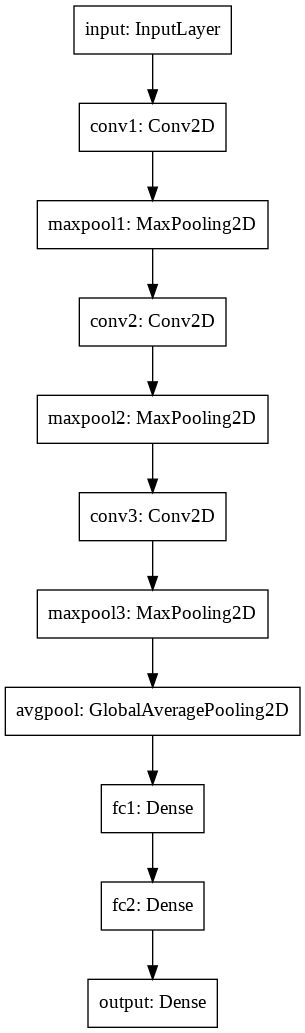

In [17]:
inputs = tf.keras.Input(shape=(224, 224, 3), name='input')

conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', name='conv1')(inputs)
maxpool1 = tf.keras.layers.MaxPool2D(name='maxpool1')(conv1)

conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name='conv2')(maxpool1)
maxpool2 = tf.keras.layers.MaxPool2D(name='maxpool2')(conv2)

conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name='conv3')(maxpool2)
maxpool3 = tf.keras.layers.MaxPool2D(name='maxpool3')(conv3)

avgpool = tf.keras.layers.GlobalAveragePooling2D(name='avgpool')(maxpool3)

fc1 = tf.keras.layers.Dense(128, activation='relu', name='fc1')(avgpool)
fc2 = tf.keras.layers.Dense(128, activation='relu', name='fc2')(fc1)

outputs = tf.keras.layers.Dense(1, activation='linear', name='output')(fc2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


print(model.summary())
tf.keras.utils.plot_model(model)

# Model Training

In [18]:
model.compile(
    optimizer='adam',
    loss='mse'
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
88/88 [==============================] - 31s 345ms/step - loss: 333.2553 - val_loss: 116.1123
Epoch 2/100
88/88 [==============================] - 29s 326ms/step - loss: 106.6958 - val_loss: 88.5977
Epoch 3/100
88/88 [==============================] - 29s 329ms/step - loss: 90.8007 - val_loss: 82.2817
Epoch 4/100
88/88 [==============================] - 29s 328ms/step - loss: 90.0159 - val_loss: 86.2169
Epoch 5/100
88/88 [==============================] - 29s 328ms/step - loss: 89.1859 - val_loss: 84.5677
Epoch 6/100
88/88 [==============================] - 29s 329ms/step - loss: 87.6440 - val_loss: 83.0564
Epoch 7/100
88/88 [==============================] - 29s 326ms/step - loss: 87.1330 - val_loss: 90.4085
Epoch 8/100
88/88 [==============================] - 29s 329ms/step - loss: 86.1810 - val_loss: 80.0182
Epoch 9/100
88/88 [==============================] - 29s 329ms/step - loss: 86.1580 - val_loss: 85.2966
Epoch 10/100
88/88 [==============================] - 29s 326

# Model Evaluation

In [19]:
predicted_ages = np.squeeze(model.predict(test_images))
true_ages = test_images.labels

rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("     Test RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_ages, predicted_ages)
print("Test R^2 Score: {:.5f}".format(r2))

     Test RMSE: 9.01082
Test R^2 Score: -0.02797


In [20]:
null_rmse = np.sqrt(np.sum((true_ages - np.mean(true_ages))**2) / len(true_ages))
print("Null/Baseline Model Test RMSE: {:.5f}".format(null_rmse))

Null/Baseline Model Test RMSE: 8.88740


# Save the model

In [24]:
model.save_weights('age_model', save_format='h5')